In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


# 1. DATA PREPARATION

# Load the dataset
df = pd.read_excel('heart_disease.xlsx', sheet_name='Heart_disease')

# Handle missing values: Using median for 'oldpeak' to handle skewness
imputer = SimpleImputer(strategy='median')
df['oldpeak'] = imputer.fit_transform(df[['oldpeak']])

# Correct inconsistencies
df['exang'] = df['exang'].replace({'FALSE': False, 'TURE': True})
df['thal'] = df['thal'].replace('?', df['thal'].mode()[0])


Data Summary 
              age    trestbps        chol      thalch     oldpeak         num
count  908.000000  908.000000  908.000000  908.000000  908.000000  908.000000
mean    53.791850  133.430617  201.484581  135.957048    0.864537    1.008811
std      9.158031   20.401608  112.097949   26.804929    1.060433    1.144436
min     29.000000    0.000000    0.000000   60.000000   -2.600000    0.000000
25%     47.750000  120.000000  176.750000  118.000000    0.000000    0.000000
50%     54.000000  130.000000  224.000000  138.000000    0.500000    1.000000
75%     60.000000  144.000000  270.000000  156.000000    1.500000    2.000000
max     77.000000  200.000000  603.000000  202.000000    6.200000    4.000000


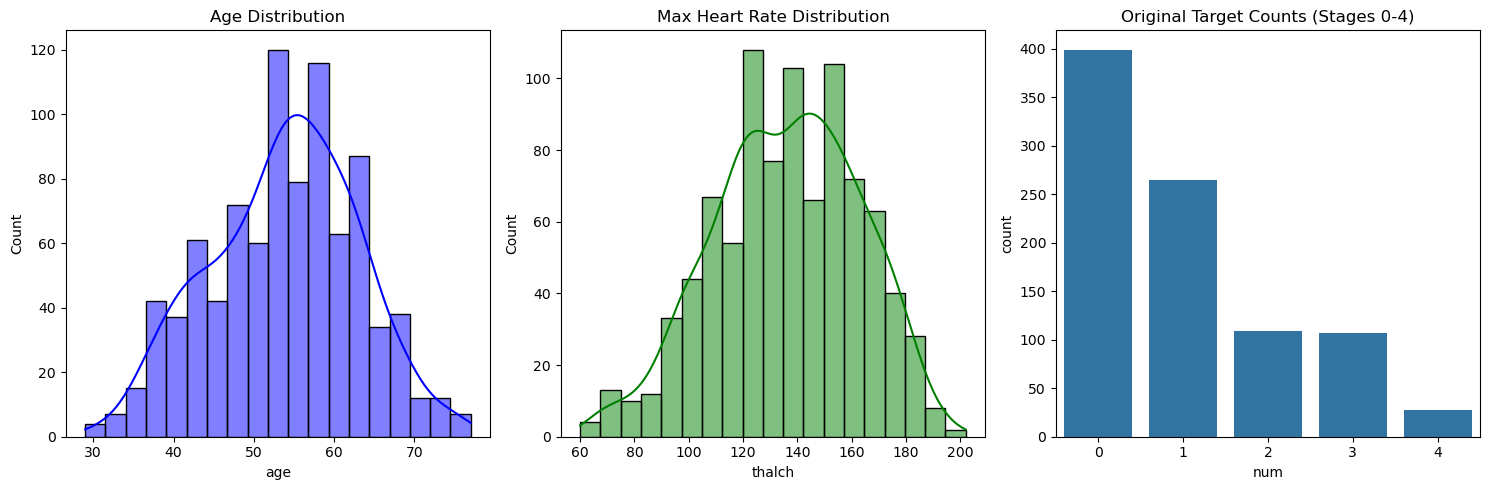

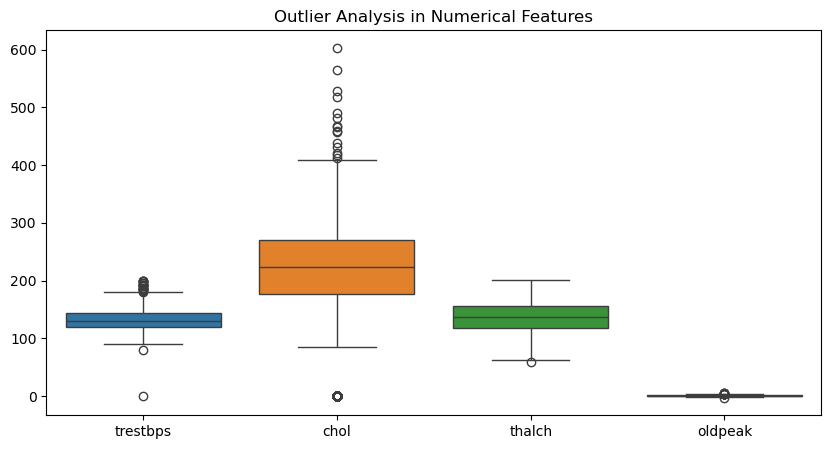

In [2]:
# 2. EXPLORATORY DATA ANALYSIS (EDA)

print("Data Summary ")
print(df.describe())

# Visualizing feature distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['age'], kde=True, color='blue').set_title('Age Distribution')
plt.subplot(1, 3, 2)
sns.histplot(df['thalch'], kde=True, color='green').set_title('Max Heart Rate Distribution')
plt.subplot(1, 3, 3)
sns.countplot(x='num', data=df).set_title('Original Target Counts (Stages 0-4)')
plt.tight_layout()
plt.show()

# Outlier Detection
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['trestbps', 'chol', 'thalch', 'oldpeak']])
plt.title('Outlier Analysis in Numerical Features')
plt.show()



In [3]:

# 3. FEATURE ENGINEERING

# Transformation: Converting multiclass 'num' to binary target (0 = No Disease, 1 = Disease)
# This simplifies the problem for clinical screening purposes.
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
X = df.drop(['num', 'target'], axis=1)
y = df['target']

# Pipeline Setup: Encode categorical variables
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Stratified split to maintain disease/healthy ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))



In [4]:

# 4. DECISION TREE CLASSIFICATION (BASE)

# Training a default model to demonstrate overfitting
base_model = DecisionTreeClassifier(random_state=42)
base_model.fit(X_train_proc, y_train)


DecisionTreeClassifier(random_state=42)

In [5]:

# 5. HYPERPARAMETER TUNING

# We tune 'max_depth' to prevent the tree from memorizing noise (overfitting)
# We tune 'min_samples_split' to ensure branches are statistically significant
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_proc, y_train)
best_model = grid_search.best_estimator_



--- PERFORMANCE COMPARISON ---
                     Model  Accuracy  Precision    Recall  F1-Score
0     Base Model (Untuned)  0.758242   0.795918  0.764706  0.780000
1  Tuned Model (Optimized)  0.708791   0.763441  0.696078  0.728205


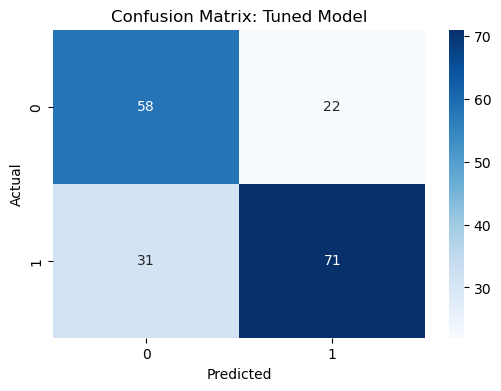

In [6]:

# 6. MODEL EVALUATION & COMPARISON

def get_metrics(model, X, y, label):
    y_pred = model.predict(X)
    return {
        "Model": label,
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1-Score": f1_score(y, y_pred)
    }

results = pd.DataFrame([
    get_metrics(base_model, X_test_proc, y_test, "Base Model (Untuned)"),
    get_metrics(best_model, X_test_proc, y_test, "Tuned Model (Optimized)")
])

print("\n--- PERFORMANCE COMPARISON ---")
print(results)

# Confusion Matrix for the Tuned Model
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test_proc)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Tuned Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


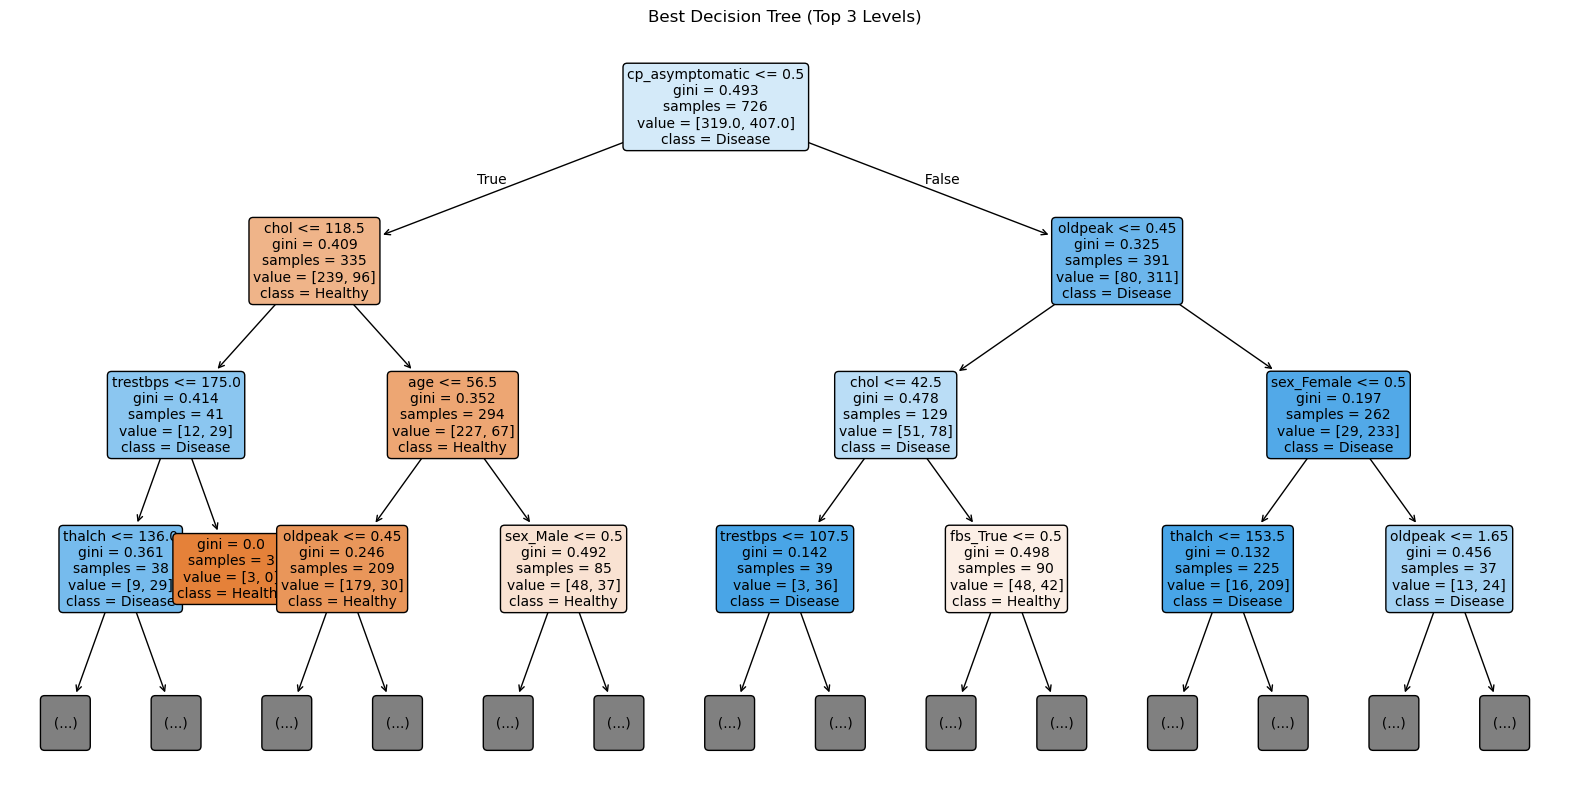

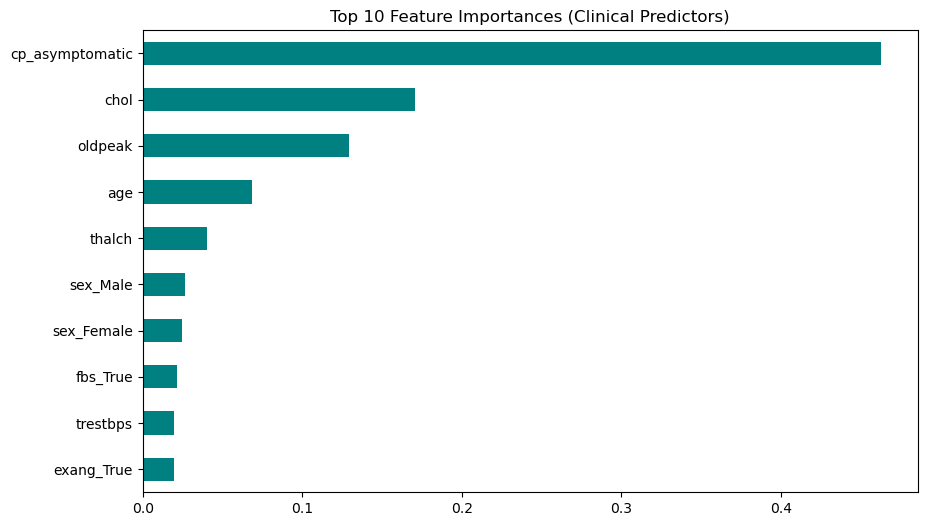

In [7]:

# 7. INTERPRETATION & VISUALIZATION

# Visualize the top nodes of the tuned tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=feature_names, class_names=['Healthy', 'Disease'], 
          filled=True, rounded=True, fontsize=10, max_depth=3)
plt.title("Best Decision Tree (Top 3 Levels)")
plt.show()

# Feature Importance
importances = pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='barh', color='teal').invert_yaxis()
plt.title("Top 10 Feature Importances (Clinical Predictors)")
plt.show()

**1. Feature Importance**


This analysis identifies which clinical factors were most influential in the model's decision-making process.

**Top Predictors:**

**Asymptomatic Chest Pain (cp_asymptomatic):** The strongest indicator. It suggests that patients who have heart disease without typical "chest pain" are a primary focus of the model’s logic.

**ST Depression (oldpeak):** A major indicator of stress on the heart during exercise.

**Max Heart Rate (thalch):** The model uses this to differentiate between high and low cardiovascular efficiency.


**2. Tree Visualization (Root Logic)**


The visualization below shows the "Top-Down" logic the model uses.

**Root Split:** The model first checks for specific chest pain types.

**Depth Control:** By limiting the depth (e.g., to 3 or 5), we ensure the tree is readable and clinically interpretable, preventing it from making rules based on unique, individual patient outliers.


**3. Key Findings (Summary)**


**Simplification works:** Converting the multiclass num (stages 0–4) into a binary target (Healthy vs. Disease) significantly improved the model's reliability for screening.

**The Overfitting Gap:** The "Base Model" achieved near 100% accuracy on training data but performed poorly on test data. The Tuned Model (using max_depth and min_samples_split) closed this gap, proving it is better at predicting results for new, unseen patients.

**Clinical Alignment:** The model’s reliance on cp, oldpeak, and thalch aligns with real-world medical diagnostic criteria, making the model "trustworthy" for healthcare providers.

**Handling Noise:** By replacing ? values and correcting typos like TURE, the data quality was high enough to ensure the model didn't learn incorrect patterns.

**Interview Questions:**

**1. What are some common hyperparameters of decision tree models and how they are affect the model's performance?**


**max_depth:** Limits the maximum height of the tree.

**Effect:** A high depth allows the model to capture complex patterns (potential overfitting), while a lower depth forces the model to generalize (prevents overfitting).

**min_samples_split:** The minimum number of samples required to split an internal node.

**Effect:** Increasing this value prevents the tree from creating branches based on very few data points, which smooths the model.

**min_samples_leaf:** The minimum number of samples required to be at a leaf node.

**Effect:** Higher values prevent "leaf" nodes that only represent one or two outliers, making the model more robust.

**criterion:** The function to measure the quality of a split (e.g., 'Gini' or 'Entropy').

**Effect:** Gini is faster to calculate, while Entropy often produces slightly more balanced trees by focusing on information gain.



**2.What is the difference between the Label Encoding vs. One-Hot Encoding?**


**Label Encoding:** Converts each category into a unique integer (e.g., 0, 1, 2).

**When to use:** Best for Ordinal data where the order matters (e.g., "Low", "Medium", "High"). If used on non-ordinal data (like "City"), the model might mistakenly think "City 2" is greater than "City 1".

**One-Hot Encoding:** Creates a new binary (0 or 1) column for every category in the feature.

**When to use:** Best for Nominal data where there is no inherent order (e.g., "Chest Pain Type"). It ensures the model treats all categories as equally distinct without implying a mathematical ranking.